In [105]:
import spacy
from spacy.tokens import Doc
from spacy.tokens import DocBin
from spacy.matcher import Matcher
from spacy.lang.char_classes import ALPHA, ALPHA_LOWER, ALPHA_UPPER, CONCAT_QUOTES, LIST_ELLIPSES, LIST_ICONS, HYPHENS
from spacy.util import compile_infix_regex

from numpy import array

import scispacy
import pandas as pd
import en_core_sci_lg
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec, KeyedVectors

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Flatten, Dropout
from tensorflow.keras.layers import TextVectorization

seed = 100

import random
import numpy as np
import tensorflow as tf
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [106]:
df1 = pd.read_csv ('data_files/positive_kinase_activity', sep='\t')
df1['Label'] = 1

df2 = pd.read_csv ('data_files/neg_sentences_kinase_activity_with_kinase.txt', sep='\t', header=None)
df2 = df2.rename(columns={0: "id", 1: "Sentence"})
df2['Label'] = 0

df = pd.concat([df1[['Sentence', 'Label']], df2[['Sentence', 'Label']]], ignore_index=True)
print(df.head())

                                            Sentence  Label
0  In mammalian cells subjected to ER stress, we ...      1
1  To address the role of C. elegans PEK in trans...      1
2  We show that recombinant CePEK phosphorylates ...      1
3                       eIF-2α kinase assay in vitro      1
4  Following a similar regimen described for the ...      1


In [107]:
#Doc.set_extension("positive", default=False)

pos_text_docs = df.loc[(df['Label'] == 1)]['Sentence'].astype(str).values.tolist()
neg_text_docs = df.loc[(df['Label'] == 0)]['Sentence'].astype(str).values.tolist()
print("Pos: ", len(pos_text_docs))
print("Neg: ", len(neg_text_docs))

nlp = spacy.load("en_core_sci_md")

pos_docs = list(nlp.pipe(pos_text_docs[:4000]))
neg_docs = list(nlp.pipe(neg_text_docs[:4000]))
for doc in pos_docs:
    doc._.positive = True

docs = []
docs.extend(pos_docs)
docs.extend(neg_docs)

print(len(docs))
random.shuffle(docs)

Pos:  340
Neg:  1059
1399


In [108]:
from utils.print_tree import print_tree

vocab, index = {}, 1  # start indexing from 1
vocab['<pad>'] = 0  # add a padding token


tuples = []
labels = []
for i in range(0, len(docs)):
    
    node_list = []
    edge_list = []
    sent_len = i
    #print(sent_len, ":", docs[sent_len])
    for sent in docs[sent_len].sents:
        for token in sent:
            node_list.append([token, True])
        print_tree(sent.root, node_list, edge_list, 0)    
        break

    #print(vocab)
    for edge in edge_list:
        if edge[0].text.lower() not in vocab:
            vocab[edge[0].text.lower()] = index
            index += 1
        if edge[1].text.lower() not in vocab:
            vocab[edge[1].text.lower()] = index
            index += 1
            
        tuples.append([vocab[str(edge[0]).lower()], vocab[str(edge[1]).lower()]])
        
        if docs[sent_len]._.positive:
            labels.append(1)
        else:
            labels.append(0)

inverse_vocab = {index: token for token, index in vocab.items()}
vocab_size = len(vocab)
print("Vocab Size", vocab_size)

print(len(tuples))
print(len(labels))

#print(tuples[:300])
#print(inverse_vocab)

Vocab Size 6939
25671
25671


In [109]:
tuples = array(tuples)
labels = array(labels)

print(tuples)
print(labels)

from sklearn.model_selection import train_test_split

data_train, data_test, labels_train, labels_test = train_test_split(tuples, labels, test_size=0.20)
data_val, data_test, labels_val, labels_test = train_test_split(data_test, labels_test, test_size=0.50)


[[   1    2]
 [   2    3]
 [   3    4]
 ...
 [ 271  774]
 [ 774 2233]
 [ 273 1132]]
[0 0 0 ... 1 1 1]


In [117]:
model = Sequential()
model.add(Embedding(vocab_size, 3, input_length=2))
model.add(Flatten())
model.add(Dropout(0.6))
#model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
# summarize the model
print(model.summary())

import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# fit the model
history = model.fit(data_train, labels_train, validation_data=(data_val, labels_val), epochs=50, callbacks=[tensorboard_callback])

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 2, 3)              20817     
                                                                 
 flatten_22 (Flatten)        (None, 6)                 0         
                                                                 
 dropout_1 (Dropout)         (None, 6)                 0         
                                                                 
 dense_25 (Dense)            (None, 1)                 7         
                                                                 
Total params: 20,824
Trainable params: 20,824
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
642/642 [==============================] - 2s 2ms/step - loss: 0.5974 - accuracy: 0.8052 - precision: 0.1807 - recall: 0.0514 - val_loss: 0.5203 - val_accuracy: 0.83

642/642 [==============================] - 1s 2ms/step - loss: 0.1827 - accuracy: 0.9218 - precision: 0.8482 - recall: 0.6403 - val_loss: 0.1891 - val_accuracy: 0.9264 - val_precision: 0.8857 - val_recall: 0.6458
Epoch 34/50
642/642 [==============================] - 1s 2ms/step - loss: 0.1832 - accuracy: 0.9229 - precision: 0.8562 - recall: 0.6400 - val_loss: 0.1894 - val_accuracy: 0.9283 - val_precision: 0.8899 - val_recall: 0.6551
Epoch 35/50
642/642 [==============================] - 1s 2ms/step - loss: 0.1843 - accuracy: 0.9214 - precision: 0.8532 - recall: 0.6317 - val_loss: 0.1884 - val_accuracy: 0.9283 - val_precision: 0.8875 - val_recall: 0.6574
Epoch 36/50
642/642 [==============================] - 1s 2ms/step - loss: 0.1798 - accuracy: 0.9230 - precision: 0.8597 - recall: 0.6370 - val_loss: 0.1900 - val_accuracy: 0.9279 - val_precision: 0.8871 - val_recall: 0.6551
Epoch 37/50
642/642 [==============================] - 1s 1ms/step - loss: 0.1800 - accuracy: 0.9241 - precision

In [118]:
# evaluate the model
print("Test Set Size: ", len(data_test))
loss, accuracy, precision, recall = model.evaluate(data_test, labels_test)
print('Accuracy: %f' % (accuracy*100))

#model.save('models/kinase_sentence_model02')

Test Set Size:  2568
81/81 [==============================] - 0s 823us/step - loss: 0.1852 - accuracy: 0.9237 - precision: 0.8766 - recall: 0.6382
Accuracy: 92.367601


In [119]:
import io

word_embeddings_layer = model.layers[0]
weights = word_embeddings_layer.get_weights()[0]
print("Word Embeddings shape: %s" % (weights.shape,))

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num in range(0, vocab_size):
    vec = weights[num] # skip 0, it's padding.
    out_m.write(inverse_vocab[num] + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

Word Embeddings shape: (6939, 3)


In [120]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

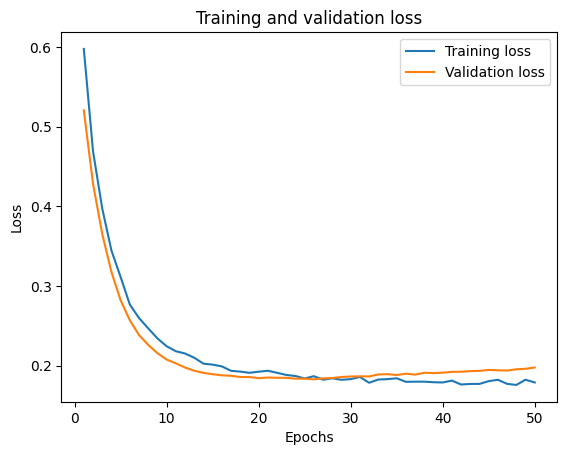

In [121]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label="Training loss")
plt.plot(epochs, val_loss_values, label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

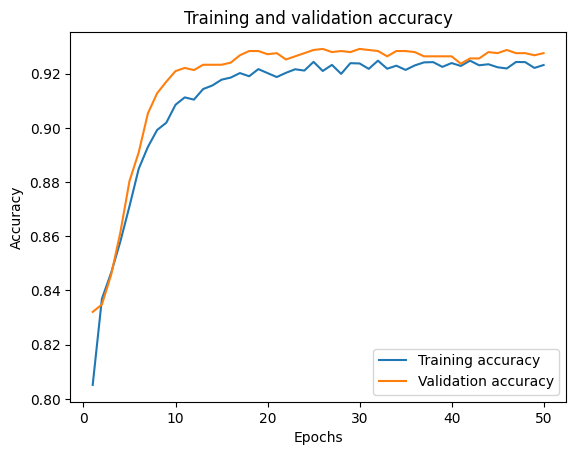

In [122]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

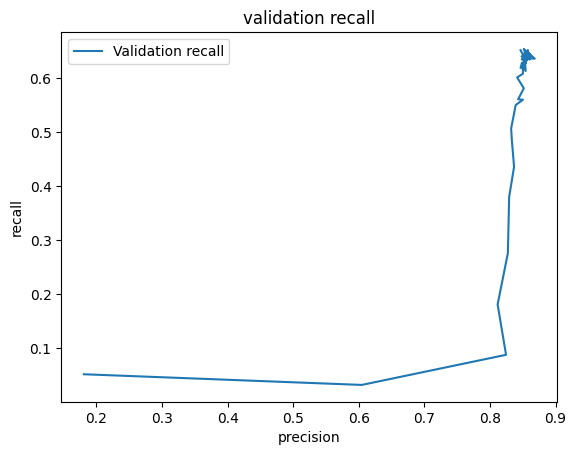

In [123]:
plt.clf()
acc = history.history["precision"]
val_acc = history.history["recall"]
plt.plot(acc, val_acc, label="Validation recall")
plt.title("validation recall")
plt.xlabel("precision")
plt.ylabel("recall")
plt.legend()
plt.show()